In [1]:
############ Machine Learning ###############
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import classification_report

import optuna
import lightgbm as lgb
import category_encoders as ce

############# Visualization ################
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Noto Sans CJK JP','Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', ]
%matplotlib inline

########## For Google Colab ################
# from google.colab import drive
# drive.mount('/content/drive')
# train = pd.read_csv('/content/drive/My Drive/Titanic/train.csv')
# test = pd.read_csv('/content/drive/My Drive/Titanic/test.csv')

############## For Local ###################
train_raw = pd.read_csv('./data/raw/train.csv')
test_raw = pd.read_csv('./data/raw/test.csv')
gender_submission = pd.read_csv('./data/raw/gender_submission.csv')

In [2]:
data = pd.concat([train_raw,test_raw],sort=False)

data['honorific'] = data['Name'].map(lambda x : x.split(', ')[1].split('.')[0])
data['honorific'] = data['honorific'].replace(\
['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona','the Countess'], 'Rare')
data['honorific'] = data['honorific'].replace({'Mme':'Mrs','Ms':'Miss','Mlle':'Miss'})
data['Fare'].fillna(np.mean(data['Fare']),inplace=True)
#data['Farebin'] = pd.qcut(data['Fare'],4)
for i in range(1,4):
    data.loc[(data['Pclass']==i)&(data['Age'].isnull()),'Age'] = data[data['Pclass']==i]['Age'].mean()
#data['Agebin'] = pd.cut(data['Age'].astype(int),5)
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1 # 本人の＋１
data['FamilySize_bin'] = 4
data.loc[data['FamilySize']==1,'FamilySize_bin'] = 1
data.loc[(data['FamilySize']>=2)&(data['FamilySize']<=5),'FamilySize_bin'] = 2
data.loc[(data['FamilySize']>=6)&(data['FamilySize']<=8),'FamilySize_bin'] = 3
data['Cabin_initial'] = data['Cabin'].map(lambda x:str(x)[0])
data['Survived'].groupby(data['Cabin_initial']).mean()
data['Cabin_initial'] = data['Cabin_initial'].replace('T','n')
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].fillna('S',inplace=True)
data['Embarked']=data['Embarked'].map({'S':0,'C':1,'Q':2}).astype(int)
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket','Cabin','FamilySize']
data.drop(delete_columns, axis=1, inplace=True)

# ラベルエンコーディング
label_category = ['honorific','FamilySize_bin','Cabin_initial','Pclass']
ce_oe = ce.OrdinalEncoder(cols=label_category,handle_unknown='impute')
data = ce_oe.fit_transform(data)

# １からではなく、０から始まりに修正
for i in label_category:
    data[i] = data[i] -1 
#     data[i] = data[i].astype('category')

# 元データに戻す
train_df, test_df = data[:len(train_raw)], data[len(train_raw):]
X_train_df, y_train_df = train_df.drop('Survived',axis=1), train_df['Survived']
X_test_df = test_df.drop('Survived',axis=1)

In [145]:
def objective(trial):
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_df,y_train_df, \
                                                    test_size=0.3, random_state=0, stratify=y_train_df)
    
    params = {
        # Fixed
        'objective': 'binary',
        'learning_rate': 0.05,
        
        # Variable
        'max_bin': trial.suggest_int('max_bin', 255, 500),
        'num_leaves': trial.suggest_int('num_leaves', 32, 128),
    }

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model = lgb.train(params, lgb_train,
                    valid_sets=[lgb_train, lgb_eval],
                    verbose_eval=10,
                    num_boost_round=1000,
                    early_stopping_rounds=10)

    y_pred_valid = model.predict(X_valid,num_iteration=model.best_iteration)
    score = log_loss(y_valid,y_pred_valid)

    return score

# Optunaによる最適化
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)
study.best_params


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967


[I 2020-01-17 15:24:44,611] Finished trial#0 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967


[I 2020-01-17 15:24:44,834] Finished trial#1 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.
[I 2020-01-17 15:24:45,044] Finished trial#2 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967


[I 2020-01-17 15:24:45,243] Finished trial#3 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds


[I 2020-01-17 15:24:45,443] Finished trial#4 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762


[I 2020-01-17 15:24:45,644] Finished trial#5 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672


[I 2020-01-17 15:24:45,844] Finished trial#6 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432


[I 2020-01-17 15:24:46,053] Finished trial#7 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835


[I 2020-01-17 15:24:46,272] Finished trial#8 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967


[I 2020-01-17 15:24:46,474] Finished trial#9 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967


[I 2020-01-17 15:24:46,647] Finished trial#10 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.
[I 2020-01-17 15:24:46,845] Finished trial#11 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds


[I 2020-01-17 15:24:47,045] Finished trial#12 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194


[I 2020-01-17 15:24:47,250] Finished trial#13 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194


[I 2020-01-17 15:24:47,452] Finished trial#14 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194


[I 2020-01-17 15:24:47,674] Finished trial#15 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194


[I 2020-01-17 15:24:47,884] Finished trial#16 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194


[I 2020-01-17 15:24:48,090] Finished trial#17 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672


[I 2020-01-17 15:24:48,292] Finished trial#18 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432


[I 2020-01-17 15:24:48,501] Finished trial#19 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432


[I 2020-01-17 15:24:48,723] Finished trial#20 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835


[I 2020-01-17 15:24:48,905] Finished trial#21 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967


[I 2020-01-17 15:24:49,102] Finished trial#22 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967


[I 2020-01-17 15:24:49,297] Finished trial#23 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.
[I 2020-01-17 15:24:49,502] Finished trial#24 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967


[I 2020-01-17 15:24:49,701] Finished trial#25 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds


[I 2020-01-17 15:24:49,899] Finished trial#26 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194


[I 2020-01-17 15:24:50,102] Finished trial#27 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672


[I 2020-01-17 15:24:50,323] Finished trial#28 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432


[I 2020-01-17 15:24:50,525] Finished trial#29 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432


[I 2020-01-17 15:24:50,727] Finished trial#30 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835


[I 2020-01-17 15:24:50,927] Finished trial#31 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474


[I 2020-01-17 15:24:51,127] Finished trial#32 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967


[I 2020-01-17 15:24:51,323] Finished trial#33 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967


[I 2020-01-17 15:24:51,528] Finished trial#34 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967


[I 2020-01-17 15:24:51,738] Finished trial#35 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967


[I 2020-01-17 15:24:51,943] Finished trial#36 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967


[I 2020-01-17 15:24:52,143] Finished trial#37 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.
[I 2020-01-17 15:24:52,341] Finished trial#38 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
Training until validation scores don't improve for 10 rounds


[I 2020-01-17 15:24:52,545] Finished trial#39 resulted in value: 0.4049668082148141. Current best value is 0.4049668082148141 with parameters: {'max_bin': 427, 'num_leaves': 79}.


[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967


{'max_bin': 427, 'num_leaves': 79}

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.498259	valid_1's binary_logloss: 0.51762
[20]	training's binary_logloss: 0.420804	valid_1's binary_logloss: 0.453194
[30]	training's binary_logloss: 0.375385	valid_1's binary_logloss: 0.426672
[40]	training's binary_logloss: 0.34508	valid_1's binary_logloss: 0.416432
[50]	training's binary_logloss: 0.321939	valid_1's binary_logloss: 0.414835
[60]	training's binary_logloss: 0.300053	valid_1's binary_logloss: 0.408474
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
[80]	training's binary_logloss: 0.266462	valid_1's binary_logloss: 0.411209
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.281982	valid_1's binary_logloss: 0.404967
--------------------------------------------------------------------------------
                  0.0         1.0  accuracy   macro avg  weighted avg
precision    0.833333    0.878049  0.847015    0.855691      0.850519
r

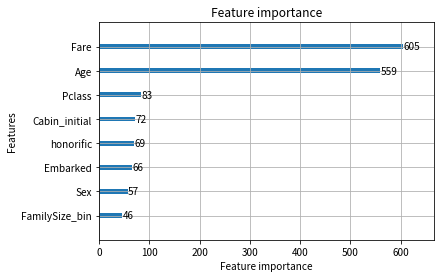

In [155]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_df,y_train_df, \
                                                    test_size=0.3, random_state=0, stratify=y_train_df)



lgb_train = lgb.Dataset(data = X_train, label = y_train)
lgb_eval = lgb.Dataset(data = X_valid, label = y_valid, reference=lgb_train)

params = {
    'objective': 'binary',
    'max_bin':427,
    'learning_rate':0.05,
    'num_leaves':79
}

evaluation_results = {}
model = lgb.train(params, lgb_train,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=10,
                  num_boost_round=1000,
                  early_stopping_rounds=10,
                 evals_result=evaluation_results)
#model.save_model('/content/drive/My Drive/Titanic/model.txt')

y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
y_pred = (y_pred > 0.5).astype(int)
y_pred_df  = pd.DataFrame(classification_report(y_valid, y_pred, output_dict = True))
print('-'*80)
print(y_pred_df)
print('-'*80)
lgb.plot_importance(model)
plt.show()

### スコア提出

In [172]:
y_pred_real = model.predict(X_test_df, num_iteration=model.best_iteration)
y_pred_real = (y_pred_real > 0.5).astype(int)

submission = pd.DataFrame(pd.read_csv('./data/raw/test.csv')['PassengerId'])
submission['Survived'] = y_pred_real
submission.to_csv('./data/submmit/titanic_fin_20200117.csv', index=False)
